In [2]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                          UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
import keras
import tensorflow as tf
from keras import callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import applications
from keras.models import Model, Input


Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [3]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())


In [4]:
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [5]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [3]:
datadir = 'D:\sapienza\ML\MWI-Dataset'


In [4]:
testdir = 'D:\sapienza\ML\Weather_dataset'


In [5]:
batch_size = 20
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.4,\
    rotation_range=60,\
    width_shift_range=0.3,\
    height_shift_range=0.3,\
    horizontal_flip=True,\
    shear_range=0.3,
    zca_whitening=True,
    brightness_range=[0.5, 1.5],
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=datadir,
    target_size=(350, 450),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testdir,
    target_size=(350, 450),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=7
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

C:\Users\Theo\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 400 images belonging to 4 classes.
Found 3038 images belonging to 4 classes.


In [6]:
classnames

['HAZE', 'RAINY', 'SNOWY', 'SUNNY']

In [33]:
def load_backbone_net(input_shape):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load a pretrained model on imagenet without the final dense layer
    feature_extractor = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input0)
    
    
    feature_extractor = feature_extractor.output
    feature_extractor = Model(input=input0, output=feature_extractor)
    optimizer = 'SGD' #alternative 'SGD'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.SGD(lr=1e-3,momentum=0.9,nesterov=True), metrics=['accuracy'])

    return feature_extractor


In [34]:
def transferNet(feature_extractor, num_classes, output_layer_name, trainable_layers):
    
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
        if layer.name in trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense = Dropout(0.4)(flatten_norm)
    #dense = Dense(200, activation='relu')(dense)
    #dense = BatchNormalization()(dense)
    
    # add a Dense layer
    #dense = Dropout(0.4)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.2)(dense)

    # add the final output layer
    dense = BatchNormalization()(dense)
    dense = Dense(num_classes, activation='softmax')(dense)
    

    model = Model(input=input_t, output=dense, name="transferNet")
    
   # optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.SGD(lr=1e-3,nesterov=True,momentum=0.9), metrics=['accuracy'])

    return model

In [35]:
# load the pre-trained model
feature_extractor = load_backbone_net(input_shape)
feature_extractor.summary()


# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(feature_extractor, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

C:\Users\Theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 350, 450, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 450, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 450, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 225, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175, 225, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 175, 225, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 87, 112, 128)      0         
__________

C:\Users\Theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="transferNet", inputs=Tensor("in..., outputs=Tensor("de...)`


In [24]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# tf.global_variables_initializer()

# with tf.Session() as sess:
#      sess.run(tf.global_variables_initializer())

In [25]:
#keras.backend.get_session().run(tf.global_variables_initializer())

In [36]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf6", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [37]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_acc', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

try:
    history_transfer = transfer_model.fit_generator(train_generator, epochs=20, verbose=1, callbacks=[stopping,checkpointer],\
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=val_steps,
                    use_multiprocessing=True,
                    workers=0)
except KeyboardInterrupt:
    pass

Epoch 1/20


C:\Users\Theo\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Theo\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/20 [=====================>........] - ETA: 10s - loss: 1.3762 - acc: 0.5067

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


20/20 [==============================] - 197s 10s/step - loss: 1.3165 - acc: 0.5275 - val_loss: 1.9938 - val_acc: 0.3618

Epoch 00001: val_acc improved from -inf to 0.36175, saving model to best_weights.hdf6
Epoch 2/20
20/20 [==============================] - 198s 10s/step - loss: 1.0183 - acc: 0.6275 - val_loss: 2.0303 - val_acc: 0.3845

Epoch 00002: val_acc improved from 0.36175 to 0.38446, saving model to best_weights.hdf6
Epoch 3/20
20/20 [==============================] - 197s 10s/step - loss: 0.7958 - acc: 0.6950 - val_loss: 2.3253 - val_acc: 0.3752

Epoch 00003: val_acc did not improve from 0.38446
Epoch 4/20
20/20 [==============================] - 193s 10s/step - loss: 0.7444 - acc: 0.7275 - val_loss: 1.8182 - val_acc: 0.4338

Epoch 00004: val_acc improved from 0.38446 to 0.43384, saving model to best_weights.hdf6
Epoch 5/20
20/20 [==============================] - 194s 10s/step - loss: 0.6437 - acc: 0.7650 - val_loss: 1.9274 - val_acc: 0.4095

Epoch 00005: val_acc did not imp

In [ ]:
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps, use_multiprocessing=True,workers=0)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

In [27]:
transfer_model.load_weights('best_weights.hdf6')


In [28]:
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


152/152 [==============================] - 130s 854ms/step
              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.152     0.282     0.198       521
       SNOWY      0.690     0.559     0.618      1421
       SUNNY      0.513     0.209     0.297      1096

   micro avg      0.385     0.385     0.385      3038
   macro avg      0.339     0.263     0.278      3038
weighted avg      0.534     0.385     0.430      3038



In [25]:
# predictions from transferNet
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
    for j in range(0,cm.shape[1]):
        if (i!=j and cm[i][j]>0):
            conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
    print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

152/152 [==============================] - 130s 855ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SUNNY            ->  SNOWY             	441 	14.52 % 
SUNNY            ->  RAINY             	317 	10.43 % 
SNOWY            ->  RAINY             	210 	6.91 % 
SUNNY            ->  HAZE              	177 	5.83 % 
RAINY            ->  SNOWY             	141 	4.64 % 
RAINY            ->  HAZE              	128 	4.21 % 
SNOWY            ->  SUNNY             	82 	2.70 % 
SNOWY            ->  HAZE              	64 	2.11 % 


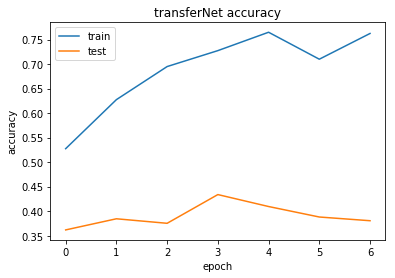

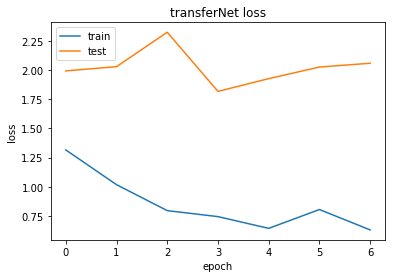

In [38]:
def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


name="transferNet"
plot_history(history_transfer, name)


In [45]:
def cross_validate(number_of_folds):
    accuracies=[]
    losses=[]
    input_shape = ()
    train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.4,\
    rotation_range=60,\
    width_shift_range=0.3,\
    height_shift_range=0.3,\
    horizontal_flip=True,\
    shear_range=0.3,
    zca_whitening=True,
    brightness_range=[0.5, 1.5],
    vertical_flip=False,
    validation_split=0.2)

    for i in  range(number_of_folds):
        random_state=np.random.randint(1,1000, 1)[0]

   
        train_generator = train_datagen.flow_from_directory(
        directory=datadir,
        target_size=(350, 450),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        subset='training',
        seed=random_state
        )

        validation_generator = train_datagen.flow_from_directory(
        directory=datadir,
        target_size=(350, 450),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        subset='validation',
        seed=random_state
        )
        
        
        num_samples = train_generator.n
        num_classes = train_generator.num_classes
        input_shape = train_generator.image_shape

        classnames = [k for k,v in train_generator.class_indices.items()]







        try:
            history_transfer = transfer_model.fit_generator(train_generator, epochs=20, verbose=0, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    use_multiprocessing=True,
                    workers=0)
        except KeyboardInterrupt:
            
            pass
        
        loss,acc = transfer_model.evaluate_generator(validation_generator,verbose=0,steps=val_steps)
        losses.append(loss)
        accuracies.append(acc)
        #print('validation loss: %f' %loss)
        #print('validation accuracy: %f' %acc)
    return accuracies,losses

In [46]:
cross_acc,cross_loss=cross_validate(5)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [47]:
cross_acc

[0.7848684219153303,
 0.7634868445365053,
 0.8039473699111688,
 0.785855264255875,
 0.7898026332259178]

In [48]:
cross_loss

[0.5806788822734043,
 0.6502082494920806,
 0.5555793182238152,
 0.5684156432551773,
 0.5672511837788319]

In [49]:
sum(cross_acc) / len(cross_acc)

0.7855921067689595

In [50]:
import statistics

In [51]:
statistics.stdev(cross_acc)


0.014524804715213481